In [1]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = False

In [3]:
# some important parameters
pre_day = 5

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing


### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
visualize_failure_timeline(failure_sessions)

In [6]:
if performe_visualization:
    # Visualize the raw data
    visualize_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

In [7]:
# remove unused columns
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

### Anomoly Detection

In [8]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed: 244163


### Missing Value Imputation

In [9]:
imputed_df = missing_value_imputation(
    filtered_data, feature_cols, 
    time_col='event_local_time', 
    device_col='device_name', 
    short_gap_limit=0, 
    long_fill_value=0.0, 
    add_missing_mask=True
    )
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Downsampling

In [10]:
downsampled_data = downsample_inverter_raw(imputed_df, drop_empty_bins=False)
downsampled_data.dropna(inplace=True) # NaN will be generated by downsampling, so we drop them

Downsampling 6126272 rows using following method: 
                                               Column Aggregation
0                       metric.AC_VOLTAGE_AB.MEASURED        mean
1                       metric.AC_VOLTAGE_BC.MEASURED        mean
2                       metric.AC_VOLTAGE_CA.MEASURED        mean
3                          metric.DC_VOLTAGE.MEASURED        mean
4                            metric.AC_POWER.MEASURED        mean
5               metric.AC_VOLTAGE_AB.MEASURED_missing        mean
6               metric.AC_VOLTAGE_BC.MEASURED_missing        mean
7               metric.AC_VOLTAGE_CA.MEASURED_missing        mean
8                  metric.DC_VOLTAGE.MEASURED_missing        mean
9                    metric.AC_POWER.MEASURED_missing        mean
10       metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED         max
11               metric.STATUS_INTERNAL_TEMP.MEASURED         max
12  metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_m...        mean
13       metric.STATUS_IN

In [11]:
if performe_visualization:
    # Visualize the downsampled data
    visualize_mean_values(
        downsampled_data, 
        failure_sessions, 
        extended_feature_cols, 
        'visualization', 
        'downsampled_data',
        freq=None
    )

### Data Cleaning

In [12]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (61, 6)
Excluded 2 periods, remaining data size: 47
Excluded 2 periods, remaining data size: 47
failure_sessions shape: (47, 7)


In [13]:
visualize_failure_timeline(filtered_sessions)

In [14]:
print("inverter_data shape:", downsampled_data.shape)
downsampled_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", downsampled_data.shape)

inverter_data shape: (1021056, 16)
Excluded 2 periods, remaining data size: 862112
Excluded data shape: (862112, 16)


### Data Labeling

In [15]:
downsampled_data = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 5584
Total rows: 837811


### Feature Engineering

In [16]:
# month_of_year 範圍 1~12
downsampled_data['month_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)
downsampled_data['month_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)

# 如果還有 hour_of_day (0~23) 也可以同理轉
downsampled_data['hour_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)
downsampled_data['hour_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)

extended_feature_cols += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

In [17]:
v = downsampled_data[['metric.AC_VOLTAGE_AB.MEASURED','metric.AC_VOLTAGE_BC.MEASURED','metric.AC_VOLTAGE_CA.MEASURED']]
v_mean = v.mean(axis=1)
v_range = v.max(axis=1) - v.min(axis=1)
downsampled_data['V_mean'] = v_mean
downsampled_data['V_unbalance'] = v_range / (v_mean + 1e-6)

extended_feature_cols += ['V_mean', 'V_unbalance']

In [18]:
if performe_visualization:
    visualize_mean_values(downsampled_data, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data', freq=None)

### Split Dataset

In [19]:
split_time = [pd.Timestamp('2024-06-30'), pd.Timestamp('2025-01-01')]


train_df = downsampled_data[downsampled_data['event_local_time'] <= split_time[0]].copy()
val_df = downsampled_data[(downsampled_data['event_local_time'] > split_time[0]) & (downsampled_data['event_local_time'] <= split_time[1])].copy()
test_df = downsampled_data[downsampled_data['event_local_time'] > split_time[1]].copy()

In [20]:
print('train set period:', train_df['event_local_time'].min(), train_df['event_local_time'].max())
print('validation set period:', val_df['event_local_time'].min(), val_df['event_local_time'].max())
print('test set period:', test_df['event_local_time'].min(), test_df['event_local_time'].max())

train set period: 2021-12-24 00:00:00 2024-06-30 00:00:00
validation set period: 2024-06-30 00:30:00 2025-01-01 00:00:00
test set period: 2025-01-01 00:30:00 2025-07-23 23:30:00


In [21]:
extended_feature_cols

['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED',
 'metric.STATUS_INTERNAL_TEMP.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing',
 'metric.STATUS_INTERNAL_TEMP.MEASURED_missing',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos',
 'V_mean',
 'V_unbalance']

### Standardization

In [22]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols + ['V_mean', 'V_unbalance']
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [23]:
if performe_visualization or True:
    visualize_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data', freq=None)
    visualize_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data', freq=None)
    visualize_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data', freq=None)

Writing HTML: 100%|██████████| 16/16 [02:56<00:00, 11.03s/it]


Visualization saved at visualization/train_data (raw)/*.html


Writing HTML: 100%|██████████| 16/16 [00:47<00:00,  2.98s/it]


Visualization saved at visualization/val_data (raw)/*.html


Writing HTML: 100%|██████████| 16/16 [00:48<00:00,  3.03s/it]

Visualization saved at visualization/test_data (raw)/*.html


### Create Dataset/Data Loader

In [24]:
from torch.utils.data import DataLoader
window_size = 2*24*7 # 30 minutes*2*24*7 = 7 days
normal_stride = 2*6 # 30 minutes*2*6 = 6 hours
positive_sample_stride = 2

positive_ds = PositiveInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=positive_sample_stride)
negative_ds = NegativeInverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=normal_stride)

train_ds = combine_dataset([positive_ds, negative_ds])
val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=normal_stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=normal_stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 44.39it/s]


In [25]:
# information of datasets
print("train_ds.X.shape:", train_ds.X.shape)
print("val_ds.X.shape:", val_ds.X.shape)
print("test_ds.X.shape:", test_ds.X.shape)

train_ds.X.shape: torch.Size([44504, 336, 20])
val_ds.X.shape: torch.Size([11270, 336, 20])
test_ds.X.shape: torch.Size([10979, 336, 20])


In [26]:
label_dis = pd.value_counts(train_ds.y.numpy())
train_pos_ration = label_dis[1] / (label_dis[0] + label_dis[1])
label_dis = pd.value_counts(val_ds.y.numpy())
val_pos_ration = label_dis[1] / (label_dis[0] + label_dis[1])
label_dis = pd.value_counts(test_ds.y.numpy())
test_pos_ration = label_dis[1] / (label_dis[0] + label_dis[1])

print("train pos ratio:", train_pos_ration)
print("val pos ratio:", val_pos_ration)
print("test pos ratio:", test_pos_ration)

train pos ratio: 0.04314218946611541
val pos ratio: 0.005323868677905945
test pos ratio: 0.005464978595500501


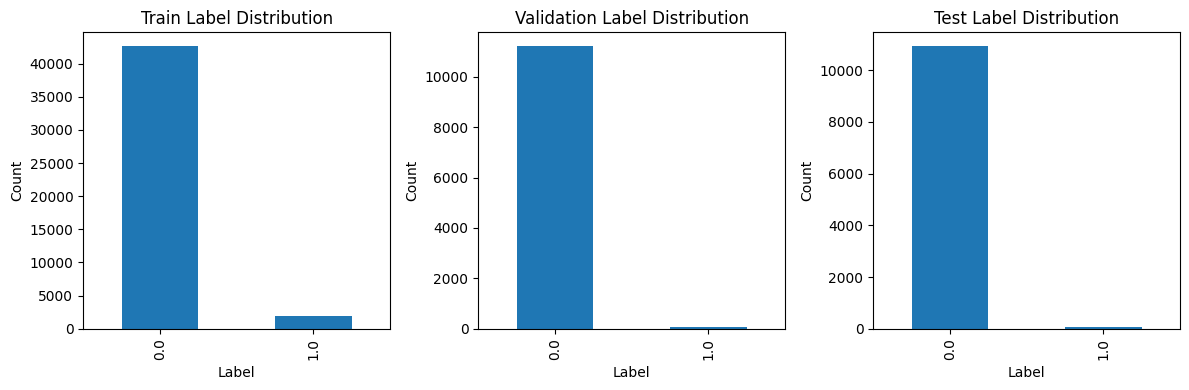

In [27]:
import matplotlib.pyplot as plt

# 計算各資料集的標籤分佈
train_counts = pd.Series(train_ds.y.numpy()).value_counts()
val_counts   = pd.Series(val_ds.y.numpy()).value_counts()
test_counts  = pd.Series(test_ds.y.numpy()).value_counts()

# 畫圖
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, counts, title in zip(
    axes,
    [train_counts, val_counts, test_counts],
    ["Train", "Validation", "Test"]
):
    counts.plot(kind='bar', ax=ax)
    ax.set_title(f"{title} Label Distribution")
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 取出標籤（假設 train_ds.y 是 0/1 的 torch.tensor）
y = train_ds.y.cpu().numpy()
assert set(np.unique(y)).issubset({0,1}), "train_ds 應只有 0/1 標籤"

num_pos = int((y == 1).sum())
num_neg = int((y == 0).sum())
p_target = 0.15 # 你可以之後調 0.2~0.35

# 權重：讓期望抽樣比例 ≈ p_target
w_pos = p_target / max(num_pos, 1)
w_neg = (1.0 - p_target) / max(num_neg, 1)
sample_weights = np.where(y == 1, w_pos, w_neg).astype(np.float64)
sample_weights = torch.from_numpy(sample_weights)

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # 每個 epoch 跑滿步數
    replacement=True
)

In [29]:
train_loader = DataLoader(
    train_ds,
    batch_size=512,         # 或你的 GPU 極限
    #sampler=balanced_sampler,
    shuffle=True,  # 如果不使用 sampler，則需要 shuffle
    num_workers=8,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)

## Train Model

In [30]:
from src.model import FocalLoss, CNNLSTMModel
from torch.optim import AdamW

model = CNNLSTMModel(
    num_features=len(extended_feature_cols),
    cnn_out_channels=32,   # 32 → 64
    lstm_hidden_size=64,  # 64 → 128
    lstm_layers=2,         # 1 → 2
    dropout=0.5
)

criterion = FocalLoss(alpha=0.75, gamma=2.0)
# 如果改用 BCE：
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.2], device=device))

optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

In [31]:
import math

steps_per_epoch = len(train_loader)
max_epochs = 30
total_steps = steps_per_epoch * max_epochs
warmup_steps = max(1, int(total_steps * 0.05))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return 0.1 + 0.9 * cosine  # 下界 0.1×

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [36]:

log = train_loop(
    model, train_loader, val_loader, 
    log_interval=25, 
    num_epochs=10, 
    optimizer=optimizer, 
    criterion=criterion,
    scheduler=scheduler,
    save_interval=1,
    #save_path='model/0814_0457'
)

Model moved to cuda
[Epoch 1/10] Step 0/86 - Loss: 0.0288
[Epoch 1/10] Step 25/86 - Loss: 0.0222
[Epoch 1/10] Step 50/86 - Loss: 0.0200
[Epoch 1/10] Step 75/86 - Loss: 0.0172
🔁 Epoch 1 finished. Avg Train Loss: 0.0244


Testing: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


[0.16283765 0.16221046 0.1629576  ... 0.33401528 0.29737303 0.31546307]
✅ avg_loss: 0.0136 | AUC-PR: 0.0368 | baseline: 0.0053 | uplift: 6.91x | P@50:0.040 R@50:0.033 | P@100:0.040 R@100:0.067 | P@200:0.040 R@200:0.133
Best model saved at epoch 1 with AUC-PR 0.0368
[Epoch 2/10] Step 0/86 - Loss: 0.0247
[Epoch 2/10] Step 25/86 - Loss: 0.0265
[Epoch 2/10] Step 50/86 - Loss: 0.0252
[Epoch 2/10] Step 75/86 - Loss: 0.0248
🔁 Epoch 2 finished. Avg Train Loss: 0.0224


Testing: 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


[0.15124205 0.15155196 0.1521481  ... 0.30539772 0.206878   0.20663118]
✅ avg_loss: 0.0130 | AUC-PR: 0.0330 | baseline: 0.0053 | uplift: 6.21x | P@50:0.020 R@50:0.017 | P@100:0.020 R@100:0.033 | P@200:0.050 R@200:0.167
[Epoch 3/10] Step 0/86 - Loss: 0.0215
[Epoch 3/10] Step 25/86 - Loss: 0.0169
[Epoch 3/10] Step 50/86 - Loss: 0.0147
[Epoch 3/10] Step 75/86 - Loss: 0.0198
🔁 Epoch 3 finished. Avg Train Loss: 0.0203


Testing: 100%|██████████| 12/12 [00:09<00:00,  1.30it/s]


[0.1312198  0.13172106 0.12928739 ... 0.39838144 0.2782702  0.30123684]
✅ avg_loss: 0.0176 | AUC-PR: 0.0314 | baseline: 0.0053 | uplift: 5.89x | P@50:0.020 R@50:0.017 | P@100:0.030 R@100:0.050 | P@200:0.055 R@200:0.183
[Epoch 4/10] Step 0/86 - Loss: 0.0157
[Epoch 4/10] Step 25/86 - Loss: 0.0211
[Epoch 4/10] Step 50/86 - Loss: 0.0208
[Epoch 4/10] Step 75/86 - Loss: 0.0216
🔁 Epoch 4 finished. Avg Train Loss: 0.0203


Testing: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]


[0.13615087 0.13650031 0.13601585 ... 0.42568457 0.38999942 0.43100786]
✅ avg_loss: 0.0141 | AUC-PR: 0.0402 | baseline: 0.0053 | uplift: 7.54x | P@50:0.020 R@50:0.017 | P@100:0.020 R@100:0.033 | P@200:0.035 R@200:0.117
Best model saved at epoch 4 with AUC-PR 0.0402
[Epoch 5/10] Step 0/86 - Loss: 0.0192
[Epoch 5/10] Step 25/86 - Loss: 0.0168
[Epoch 5/10] Step 50/86 - Loss: 0.0251
[Epoch 5/10] Step 75/86 - Loss: 0.0209
🔁 Epoch 5 finished. Avg Train Loss: 0.0201


Testing: 100%|██████████| 12/12 [00:08<00:00,  1.37it/s]


[0.13600817 0.1388176  0.1360363  ... 0.23871236 0.16500849 0.18095785]
✅ avg_loss: 0.0140 | AUC-PR: 0.0375 | baseline: 0.0053 | uplift: 7.05x | P@50:0.120 R@50:0.100 | P@100:0.070 R@100:0.117 | P@200:0.050 R@200:0.167
[Epoch 6/10] Step 0/86 - Loss: 0.0195
[Epoch 6/10] Step 25/86 - Loss: 0.0232
[Epoch 6/10] Step 50/86 - Loss: 0.0208
[Epoch 6/10] Step 75/86 - Loss: 0.0200
🔁 Epoch 6 finished. Avg Train Loss: 0.0193


Testing: 100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


[0.10361663 0.10638336 0.10671753 ... 0.3443463  0.1625802  0.16274285]
✅ avg_loss: 0.0128 | AUC-PR: 0.0505 | baseline: 0.0053 | uplift: 9.49x | P@50:0.080 R@50:0.067 | P@100:0.060 R@100:0.100 | P@200:0.055 R@200:0.183
Best model saved at epoch 6 with AUC-PR 0.0505
[Epoch 7/10] Step 0/86 - Loss: 0.0137
[Epoch 7/10] Step 25/86 - Loss: 0.0201
[Epoch 7/10] Step 50/86 - Loss: 0.0179
[Epoch 7/10] Step 75/86 - Loss: 0.0162
🔁 Epoch 7 finished. Avg Train Loss: 0.0171


Testing: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


[0.082291   0.08240664 0.08404151 ... 0.39440787 0.24564078 0.20330279]
✅ avg_loss: 0.0117 | AUC-PR: 0.0254 | baseline: 0.0053 | uplift: 4.76x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.010 R@200:0.033
[Epoch 8/10] Step 0/86 - Loss: 0.0156
[Epoch 8/10] Step 25/86 - Loss: 0.0166
[Epoch 8/10] Step 50/86 - Loss: 0.0168
[Epoch 8/10] Step 75/86 - Loss: 0.0190
🔁 Epoch 8 finished. Avg Train Loss: 0.0181


Testing: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


[0.1109715  0.11282688 0.12133876 ... 0.46659255 0.43436185 0.48237425]
✅ avg_loss: 0.0196 | AUC-PR: 0.0168 | baseline: 0.0053 | uplift: 3.15x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.005 R@200:0.017
[Epoch 9/10] Step 0/86 - Loss: 0.0183
[Epoch 9/10] Step 25/86 - Loss: 0.0156
[Epoch 9/10] Step 50/86 - Loss: 0.0179
[Epoch 9/10] Step 75/86 - Loss: 0.0229
🔁 Epoch 9 finished. Avg Train Loss: 0.0181


Testing: 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


[0.11196682 0.11545554 0.11522507 ... 0.4560923  0.34905928 0.4576912 ]
✅ avg_loss: 0.0150 | AUC-PR: 0.0236 | baseline: 0.0053 | uplift: 4.44x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.020 R@200:0.067
[Epoch 10/10] Step 0/86 - Loss: 0.0219
[Epoch 10/10] Step 25/86 - Loss: 0.0154
[Epoch 10/10] Step 50/86 - Loss: 0.0179
[Epoch 10/10] Step 75/86 - Loss: 0.0127
🔁 Epoch 10 finished. Avg Train Loss: 0.0173


Testing: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]

[0.09157924 0.09432103 0.09053741 ... 0.1706221  0.09759343 0.10747649]
✅ avg_loss: 0.0122 | AUC-PR: 0.0231 | baseline: 0.0053 | uplift: 4.35x | P@50:0.000 R@50:0.000 | P@100:0.010 R@100:0.017 | P@200:0.010 R@200:0.033
🏁 Training completed.


In [37]:
#log = pd.read_csv('model/0813_1935/training_log.csv')

In [50]:
def visualize_log(log):
    plt.plot(log['train_loss'], label='train_loss')
    plt.plot(log['val_loss'], label='val_loss')
    plt.plot(log['aucpr'], label='aucpr')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

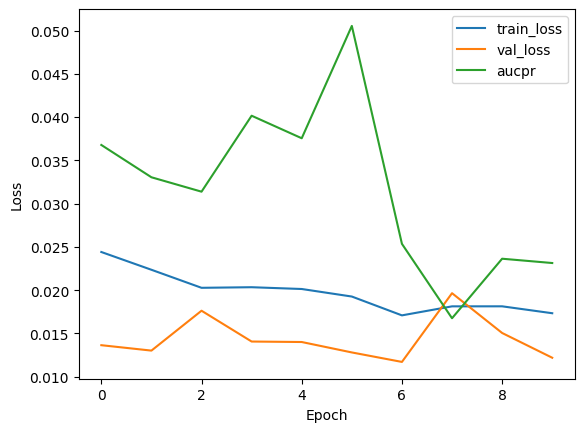

In [51]:

visualize_log(log)

### Model Evaluation

In [55]:
model.load_state_dict(torch.load(r'model\0814_1923\best_model.pth', weights_only=True))

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\_utils.py:831: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()



<All keys matched successfully>

In [56]:
# 評估 train 分佈：不用 sampler、不shuffle
train_loader_eval = DataLoader(
    train_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True
)


In [57]:
train_trues, train_outputs, train_loss= test_loop(model, train_loader_eval, criterion=criterion)


Testing: 100%|██████████| 44/44 [00:13<00:00,  3.35it/s]


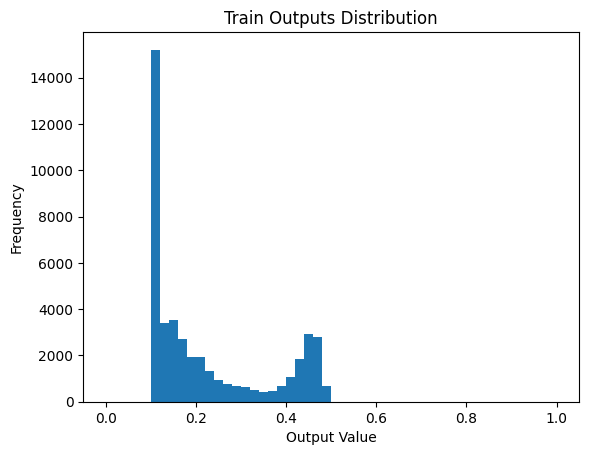

In [58]:
plot_outputs_distribution(train_outputs, "Train Outputs Distribution")

Performance on Training Set:
Train Loss: 0.016635299390393564
              precision    recall  f1-score   support

      Normal       0.99      0.79      0.88     42584
     Failure       0.16      0.91      0.28      1920

    accuracy                           0.80     44504
   macro avg       0.58      0.85      0.58     44504
weighted avg       0.96      0.80      0.85     44504

[[33663  8921]
 [  176  1744]]
ROC AUC: 0.8974


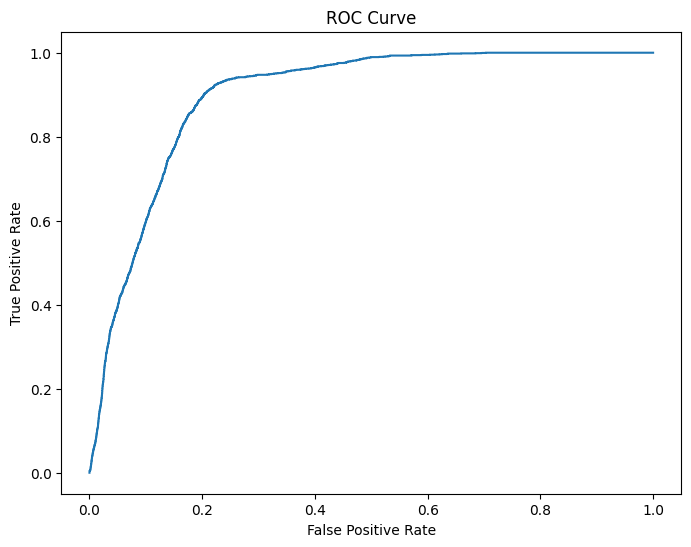

In [59]:
train_predictions = (train_outputs > 0.35).astype(int)

print("Performance on Training Set:")
print("Train Loss:", train_loss)

generate_report(train_trues, train_predictions, train_outputs)

In [ ]:
from sklearn.linear_model import LogisticRegression
from src.train import get_logits_and_labels

val_logits, val_labels = get_logits_and_labels(model, val_loader)
test_logits, test_labels = get_logits_and_labels(model, test_loader)
val_scores = torch.sigmoid(torch.tensor(val_logits)).numpy()
test_scores = torch.sigmoid(torch.tensor(test_logits)).numpy()

# === 2. Platt scaling (logistic regression) ===
platt = LogisticRegression(solver='lbfgs')
platt.fit(val_logits.reshape(-1, 1), val_labels)

# === 3. 校準分數 ===
val_probs_calibrated = platt.predict_proba(val_logits.reshape(-1, 1))[:, 1]
test_probs_calibrated = platt.predict_proba(test_logits.reshape(-1, 1))[:, 1]

# === 4. 在 val 上找最佳門檻 ===
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(val_labels, val_probs_calibrated)

target_recall = 0.8
best_idx = next(i for i,r in enumerate(recall) if r < target_recall) - 1
best_threshold = thresholds[best_idx]
print(f"Threshold for recall ≥ {target_recall}: {best_threshold:.4f}, Precision={precision[best_idx]:.3f}")

# === 5. 在 test set 上套用門檻 ===
test_preds = (test_probs_calibrated >= best_threshold).astype(int)
val_preds = (val_probs_calibrated >= best_threshold).astype(int)

Threshold for recall ≥ 0.8: 0.0156, Precision=0.024
Best threshold (F1): 0.0156
Precision: 0.0239, Recall: 0.8000


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       1.00      0.83      0.90     11210
     Failure       0.02      0.80      0.05        60

    accuracy                           0.82     11270
   macro avg       0.51      0.81      0.48     11270
weighted avg       0.99      0.82      0.90     11270

[[9249 1961]
 [  12   48]]
ROC AUC: 0.9048


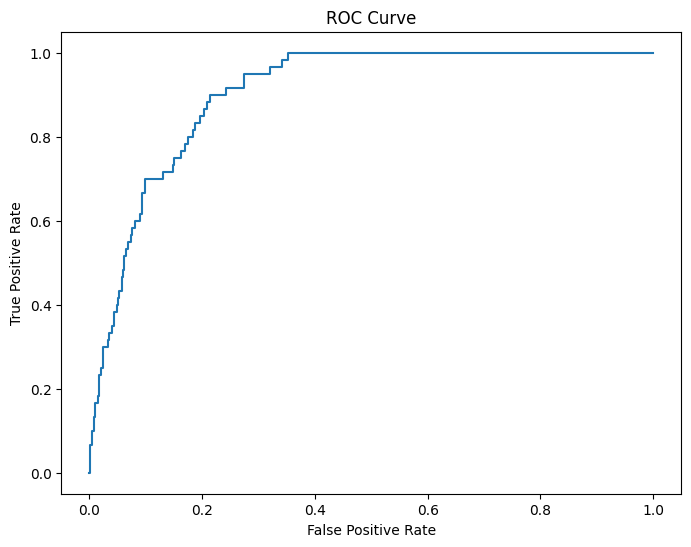

In [61]:
print("Performance on Validation Set:")
generate_report(val_labels, val_preds, val_probs_calibrated,)

Performance on Test Set:
              precision    recall  f1-score   support

      Normal       0.99      0.93      0.96     10919
     Failure       0.00      0.07      0.01        60

    accuracy                           0.92     10979
   macro avg       0.50      0.50      0.48     10979
weighted avg       0.99      0.92      0.95     10979

[[10103   816]
 [   56     4]]
ROC AUC: 0.6063


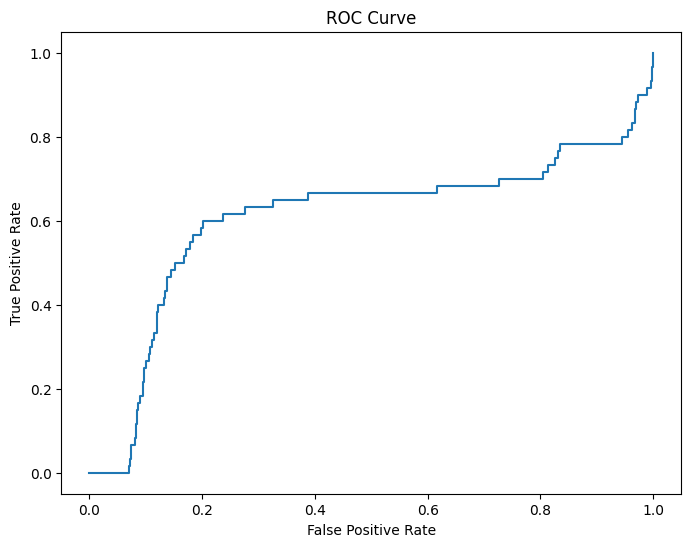

In [62]:
print("Performance on Test Set:")
generate_report(test_labels, test_preds, test_probs_calibrated,)